In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_columns',None)
data = pd.read_csv('AmesHousing.tsv',sep='\t')
working_data = data.copy()
working_data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Data cleaning

In [3]:
# We will remove all the columns which contains more than 25% null values
# To do this we will set up our cutoff value as 730
null_counts = working_data.isnull().sum()
col_to_drop = null_counts[null_counts>730].index
working_data = working_data.drop(columns=col_to_drop,axis=1)

# Let's now first work with int and float type columns
numerical_columns = working_data.select_dtypes(include=['int','float'])


# There are columns in 'numerical_columns' df which doesnot have much significance on 
# the 'SalePrice'. Like the 'Order','PID' etc. We will remove these columns
num_col_drop = ['Order','PID','Year Built','Year Remod/Add','Garage Yr Blt','Mo Sold','Yr Sold']
working_data = working_data.drop(columns=num_col_drop,axis=1)

# Lot Frontage column has lot of null values and replacing those doesnot makes
# sense. So we will delete the column.
working_data = working_data.drop(columns='Lot Frontage',axis=1)


# For now we will drop two more columns 'Sale Type' and 'Sale Condition'
# as these two column doesnot seem to have impact on Price.
working_data = working_data.drop(columns=['Sale Type','Sale Condition'],axis=1)
working_data.head()

# There are other object columns in which the data is empty. We will drop those 
# column as well
working_data = working_data.drop(columns=['Mas Vnr Type','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond'],axis=1)

In below cell we will replace all the null values present in any numeric column by its mean.

In [4]:
for col in working_data.select_dtypes(include=['float','int']).columns:
    working_data[col] = working_data[col].fillna(working_data[col].mean())

In [5]:
# Electrical column has only one null value, let's drop the corresponding row 
working_data = working_data.dropna(how='any', axis=0)

In [6]:
numerical_columns = working_data.select_dtypes(include=['int','float'])

# finding coorelation between feature and target column of numerical_columns
num_coor = numerical_columns.corr()['SalePrice'].abs().sort_values()
print(num_coor)

# setting cutoff of 0.2 for coorelation value
strong_coors = num_coor[num_coor>0.2]

BsmtFin SF 2       0.005873
Misc Val           0.015697
3Ssn Porch         0.032219
Bsmt Half Bath     0.035830
Low Qual Fin SF    0.037666
Pool Area          0.068400
MS SubClass        0.085066
Overall Cond       0.101731
Screen Porch       0.112137
Kitchen AbvGr      0.119827
Enclosed Porch     0.128811
Bedroom AbvGr      0.143925
Bsmt Unf SF        0.182788
Lot Area           0.266548
2nd Flr SF         0.269438
Bsmt Full Bath     0.275880
Half Bath          0.285202
Open Porch SF      0.312938
Wood Deck SF       0.327148
BsmtFin SF 1       0.432811
Fireplaces         0.474577
TotRms AbvGrd      0.495507
Mas Vnr Area       0.505782
Full Bath          0.545708
1st Flr SF         0.621734
Total Bsmt SF      0.632270
Garage Area        0.640382
Garage Cars        0.647892
Gr Liv Area        0.706777
Overall Qual       0.799304
SalePrice          1.000000
Name: SalePrice, dtype: float64


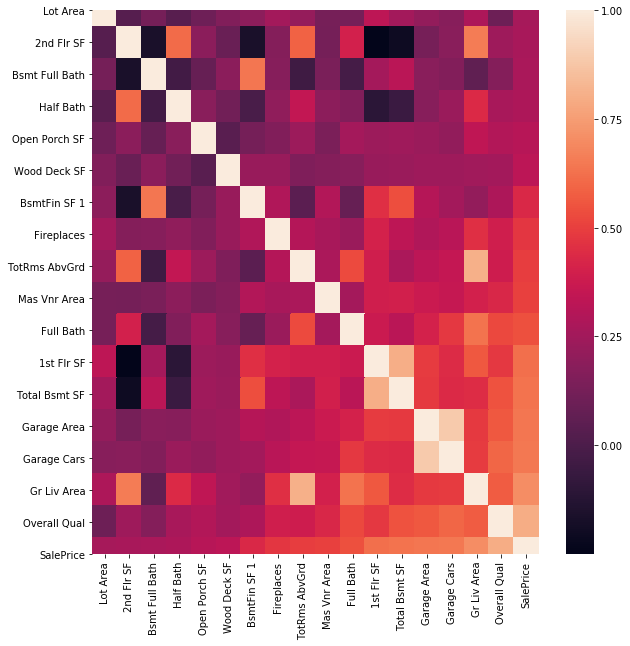

In [7]:
# generating heatmap for numerical_columns with index of strong_coors
fig = plt.figure(figsize=(10,10))
coormat = numerical_columns[strong_coors.index].corr()
ax = sns.heatmap(coormat)

From above heatmap its clear that there are few columns which are very much coorelated to each other. We will delete one of those in below cell.

In [8]:
coorelated_cols = ['TotRms AbvGrd','Garage Cars','1st Flr SF','2nd Flr SF','BsmtFin SF 1']
working_data = working_data.drop(columns=coorelated_cols,axis=1)

There are many columns of 'object' type which has very low variance or which has  lot of unique data. In either of cases it will not be a good decision to convert those column into catogorical data type and a good idea would be to delete those. In below cell we will delete those columns.

In [9]:
low_var = ['Street','Heating','Utilities','Land Slope','Neighborhood','Exterior 1st','Exterior 2nd','Condition 2','Roof Matl','Central Air','Functional','Paved Drive']
working_data = working_data.drop(columns=low_var,axis=1)

For the remaining columns which are of object type, we will convert those to category type and then we will convert to dummy columns using 'get_dummies()' function. In last step we will delete existing columns and keep only dummy ones.

In [10]:
for col in working_data.select_dtypes(include=['object']).columns:
    working_data[col] = working_data[col].astype('category')
    dummy_cols = pd.get_dummies(working_data[col],prefix=col,prefix_sep='_')
    working_data = pd.concat([working_data,dummy_cols],axis=1)
    del working_data[col]

# print first five rows of working_data
working_data.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Fireplaces,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA
0,20,31770,6,5,112.0,0.0,441.0,1080.0,0,1656,1.0,0.0,1,0,3,1,2,528.0,210,62,0,0,0,0,0,215000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,20,11622,5,6,0.0,144.0,270.0,882.0,0,896,0.0,0.0,1,0,2,1,0,730.0,140,0,0,0,120,0,0,105000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,20,14267,6,6,108.0,0.0,406.0,1329.0,0,1329,0.0,0.0,1,1,3,1,0,312.0,393,36,0,0,0,0,12500,172000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
3,20,11160,7,5,0.0,0.0,1045.0,2110.0,0,2110,1.0,0.0,2,1,3,1,2,522.0,0,0,0,0,0,0,0,244000,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,60,13830,5,5,0.0,0.0,137.0,928.0,0,1629,0.0,0.0,2,1,3,1,1,482.0,212,34,0,0,0,0,0,189900,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [11]:
def transform_features(df):
    return df

In [12]:
def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

In [13]:
def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    #selected_features = select_features()
    numerical_features = train.drop(['SalePrice'],axis=1).select_dtypes(include=['int','float'])
    lr = LinearRegression()
    lr.fit(numerical_features,train['SalePrice'])
    test_prediction = lr.predict(test[numerical_features.columns])
    mse = mean_squared_error(test['SalePrice'],test_prediction)
    rmse = mse ** (1/2)
    return rmse

transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909